In [1]:
import os
import argparse
import importlib
import map_util
import numpy as np
import matplotlib.pyplot as plt

import shapely
from shapely.ops import split
from shapely.geometry import Polygon, LineString, Point

BASE_DIR = !git rev-parse --show-toplevel
BASE_DIR = os.path.abspath(*BASE_DIR)
print(f"BASE DIR = {BASE_DIR}")
os.chdir(BASE_DIR)

BASE DIR = /home/ps2958/pps-election


# Utility function

In [15]:
def get_rotation_matrix(theta):
    """
    Set theta>0 for counter-clockwise rotation.
    Set theta<0 for clockwise rotation.
    Transpose rotation matrix to reverse rotation.
    """
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[c, -s], [s, c]])

In [3]:
MAP_LIST    = map_util.list_maps(map_util.MAP_DIRS+"/tournaments")
LOADED_MAPS = [map_util.load_map(map_file) for map_file in MAP_LIST]

In [4]:
def visualize_map(_map, ax=None, color_scheme='argmax'):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10,10))
    
    if color_scheme == 'argmax':
        colors = np.argmax(_map[:, 2:], 1)
    else:
        colors = [tuple(dist) for dist in _map[:, 2:]]

    plot = ax.scatter(_map[:,0], _map[:,1], s=0.01, c=colors, alpha=0.5, cmap='rainbow')

# 2 party 1 elector with voter count tolerance

In [5]:
def find_three_split_with_tolerance(location, winners, target, voter_tolerance=25, split_ratio=2, resolution=300, MYPARTY=0, return_top=True, debug=False):
    
    if target is None:
        target = (winners==MYPARTY).mean()

    # Calculate voter numbers required
    num_voters = int(len(location) / split_ratio)
    min_voters = num_voters - voter_tolerance
    max_voters = num_voters + voter_tolerance
    
    # Initial number of winners
    init_wins = (winners==MYPARTY).sum()
    
    # Output statistics
    thetas  = np.linspace(0, 2 * np.pi, resolution)
    ratios1 = np.zeros_like(thetas)
    ratios2 = np.zeros_like(thetas)
    idxes   = np.zeros_like(thetas, dtype=int)
    
    if target > 0.5:
        # If we have clear majority, simply attempt to maintain it
        for i, theta in enumerate(thetas):
            R = get_rotation_matrix(theta)
            new_locs = location @ R.T
            
            # Boundary line is x = x'
            sortidx = new_locs[:, 0].argsort()
            
            winner_counts = np.arange(min_voters, max_voters)
            poly1_winners = (winners[sortidx] == MYPARTY).cumsum()[min_voters: max_voters]
            poly2_winners = init_wins - poly1_winners
            
            poly1_ratio = poly1_winners / winner_counts
            poly2_ratio = poly2_winners / winner_counts[::-1]
            
            thresh = 0.50
            delta = 10. * (poly1_ratio < thresh) + 10. * (poly2_ratio < thresh)
            delta = ((poly1_ratio < target) + 1) * np.abs(poly1_ratio - target)
            delta = ((poly2_ratio < target) + 1) * np.abs(poly2_ratio - target)
            
            idxes[i]   = delta.argmin()
            ratios1[i] = poly1_ratio[idxes[i]]
            ratios2[i] = poly2_ratio[idxes[i]]
            idxes[i]  += min_voters
        
        # Threshold for heuristic function is simply majority
        thresh = 0.50

    else:
        # If it is less than 50%, split such that one district has 50% or more votes
        for i, theta in enumerate(thetas):
            R = get_rotation_matrix(theta)
            new_locs = location @ R.T
            
            # Boundary line is x=x'
            sortidx = new_locs[:, 0].argsort()
            
            winner_counts = np.arange(min_voters, max_voters)
            poly1_winners = (winners[sortidx] == MYPARTY).cumsum()[min_voters: max_voters]
            poly2_winners = init_wins - poly1_winners
            
            poly1_ratio = poly1_winners / winner_counts
            poly2_ratio = poly2_winners / winner_counts[::-1]
            
            p1_idx, p2_idx = poly1_ratio.argmax(), poly2_ratio.argmax()
            p1_max, p2_max = poly1_ratio[p1_idx], poly2_ratio[p2_idx]
            
            idxes[i]   = min_voters + (p1_idx if p1_max > p2_max else p2_idx)
            ratios1[i] = poly1_ratio[idxes[i] - min_voters]
            ratios2[i] = poly2_ratio[idxes[i] - min_voters]
            
        # Calculate threshold for heuristic function
        thresh = min(max(ratios1.max(), ratios2.max()), 0.51)

    deltas = 10. * (ratios1 <= thresh) + 10. * (ratios2 <= thresh)

    # Penalties for differences to target
    deltas += ((ratios1<target) + 1) * np.abs(ratios1-target)
    deltas += ((ratios2<target) + 1) * np.abs(ratios2-target)

    if debug:
        return thetas, deltas, ratios1, ratios2

    if return_top:
        min_idx = deltas.argmin()
        
#         print(f"Found Δ={deltas[min_idx]:0.5f} at θ={thetas[min_idx]:0.5f} "
#               f"xp_idx={idxes[min_idx]}. Split=[{ratios1[min_idx]:0.3f} {ratios2[min_idx]:0.3f}]")

        return thetas[min_idx], int(idxes[min_idx]) # TODO: Verify types

    top_deltas = deltas.argsort()[:10]
    return thetas[top_deltas], idxes[top_deltas].astype(int)

In [6]:
def split_polygon(xp, theta, polygon):
    """
    Helper function.
    Given a polygon and a theta, divides the polygon into two districts based on theta
    """
    R = get_rotation_matrix(theta)
    
    rp = Polygon(np.dstack(polygon.exterior.xy)[0] @ R.T)
    x_min, y_min, x_max, y_max = rp.bounds
    
    """ Has form x = xp """
    liney = LineString([[xp, y_min], [xp, y_max]] @ R)

    poly1, poly2 = shapely.ops.split(polygon, liney)
    
    return poly1, poly2

In [7]:
def find_recursive_split(location, winners, polygon, split_ratio, voter_tolerance, resolution, MYPARTY, return_top=False):
    # Finds the best-split line x=xp rotated about theta
    thetas, idxes = find_three_split_with_tolerance(location, winners, None, return_top=return_top,
            voter_tolerance=voter_tolerance, split_ratio=split_ratio, resolution=resolution, MYPARTY=MYPARTY)
    
    if return_top:
        thetas, idxes = [thetas], [idxes]
        
#     print(len(location))
#     print(thetas)
#     print(idxes)

    results = []
    for theta, xp_idx in zip(thetas, idxes):
        # Calculate xp and split voter locations/preferences
        R = get_rotation_matrix(theta)
        new_locs = location @ R.T
        sorted_idx = new_locs[:, 0].argsort()
        xp = new_locs[sorted_idx[xp_idx], 0]

        poly1, poly2 = split_polygon(xp, theta, polygon)

        location1, winners1 = location[sorted_idx[:xp_idx+1]], winners[sorted_idx[:xp_idx+1]]
        location2, winners2 = location[sorted_idx[xp_idx+1:]], winners[sorted_idx[xp_idx+1:]]

        if poly1.contains(Point(*location2[0])):
            poly1, poly2 = poly2, poly1
    
        results.append((theta, xp, (location1, winners1, poly1), (location2, winners2, poly2)))
        
    return results[0] if return_top else results

In [8]:
def recursively_split_threes(location, winners, polygon, voter_tolerance=25, num_splits=8, resolution=1000, MYPARTY=0):
    """
    Splits a district into two equal halves with same proportion with a penalty for < 0.50
    Outperforms recursively_split_threes
    """
    global count
    
    target = (winners==MYPARTY).mean()
    if num_splits==0:
        return int(target > 0.5), [polygon]
    
    results = find_recursive_split(
        location, winners, polygon, 3/2, voter_tolerance, resolution, MYPARTY)
    
    best_result = None
    best_delta  = np.inf
    
    for theta1, xp1, (location1, winners1, poly1), (location2, winners2, poly2) in results:
        theta2, xp2, (location1, winners1, poly1), (location3, winners3, poly3) = find_recursive_split(
            location1, winners1, poly1, 2, voter_tolerance, resolution, MYPARTY, return_top=True)
        
        ratio1, ratio2, ratio3 = (winners1==MYPARTY).mean(), (winners2==MYPARTY).mean(), (winners3==MYPARTY).mean()
        
        if target > 0.50:
            thresh = 0.50
        else:
            thresh = min(max(ratio1, ratio2, ratio3), 0.51)
        thresh = 0.50
        delta = 10. * (ratio1 <= thresh) + 10. * (ratio2 <= thresh) + 10. * (ratio3 <= thresh)

        # Penalties for differences to target
        delta += ((ratio1<target) + 1) * np.abs(ratio1-target)
        delta += ((ratio2<target) + 1) * np.abs(ratio2-target)
        delta += ((ratio3<target) + 1) * np.abs(ratio3-target)

        if delta < best_delta:
            best_delta = delta
            best_result = [(location2, winners2, poly2), (location1, winners1, poly1), (location3, winners3, poly3)]
    
    print(f"{count:-2d} Found split θ=[{np.degrees(theta1):0.2f}, {np.degrees(theta2):0.2f}] "
          f"splits={[(winners1==MYPARTY).mean(), (winners2==MYPARTY).mean(), (winners3==MYPARTY).mean()]}")
    count += 1
    
    (location2, winners2, poly2), (location1, winners1, poly1), (location3, winners3, poly3) = best_result
    win1, polys1 = recursively_split_threes(location1, winners1, poly1, voter_tolerance, num_splits-1, resolution, MYPARTY)
    win2, polys2 = recursively_split_threes(location2, winners2, poly2, voter_tolerance, num_splits-1, resolution, MYPARTY)
    win3, polys3 = recursively_split_threes(location3, winners3, poly3, voter_tolerance, num_splits-1, resolution, MYPARTY)

    return win1+win2+win3, polys1+polys2+polys3

# District Generation Script

In [9]:
MAP_LIST

['/home/ps2958/pps-election/maps/tournaments/tour2.map',
 '/home/ps2958/pps-election/maps/tournaments/tour3.map']

[111122 110803 111408]


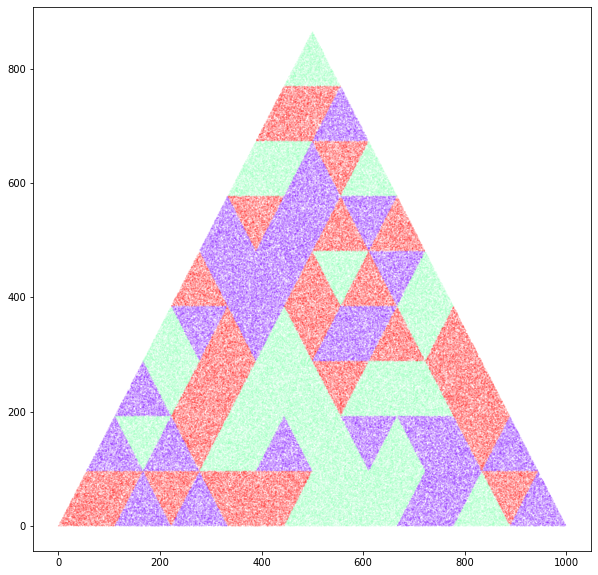

In [30]:
mmap = LOADED_MAPS[1]
visualize_map(mmap)

print(np.bincount(mmap[:,2:].argmax(1)))

In [38]:
# Code to generate 243 districts with 1 elector scheme
count = 0
location, winners = mmap[:,:2], mmap[:,2:].argmax(1)
polygon   = Polygon([[0,0], [1000,0], [500,500*np.sqrt(3)]])

num_splits = 4
voter_tolerance = np.floor(0.1 * 333333/(3**num_splits) / num_splits).astype(int)
win_counts, districts = recursively_split_threes(
    location, winners, polygon, voter_tolerance, num_splits, resolution=1000, MYPARTY=2)
print(win_counts)

 0 Found split θ=[124.32, 18.38] splits=[0.33101117519826967, 0.3409824567713625, 0.3306705528867779]
 1 Found split θ=[265.23, 99.10] splits=[0.5101078532328871, 0.3356927548713532, 0.15720253335130036]
 2 Found split θ=[27.75, 254.05] splits=[0.08336666933354668, 0.3133734156646084, 0.0809953647231032]
 3 Found split θ=[48.65, 243.24] splits=[0.0896667465835531, 0.08895131086142322, 0.08405013516834603]
 4 Found split θ=[245.41, 123.24] splits=[0.21714865550481988, 0.4642346208869814, 0.22568187303886073]
 5 Found split θ=[82.16, 269.91] splits=[0.06929716399506781, 0.1116662503122658, 0.0782608695652174]
 6 Found split θ=[115.68, 319.28] splits=[0.3309445204927933, 0.3409946344197966, 0.3302040816326531]
 7 Found split θ=[200.72, 39.64] splits=[0.083984375, 0.30793964877566166, 0.09497206703910614]
 8 Found split θ=[25.23, 22.70] splits=[0.31746822825816096, 0.34280347499413005, 0.34211150652431793]
 9 Found split θ=[326.49, 7.93] splits=[0.5052760736196319, 0.5195022732711175, 0.50

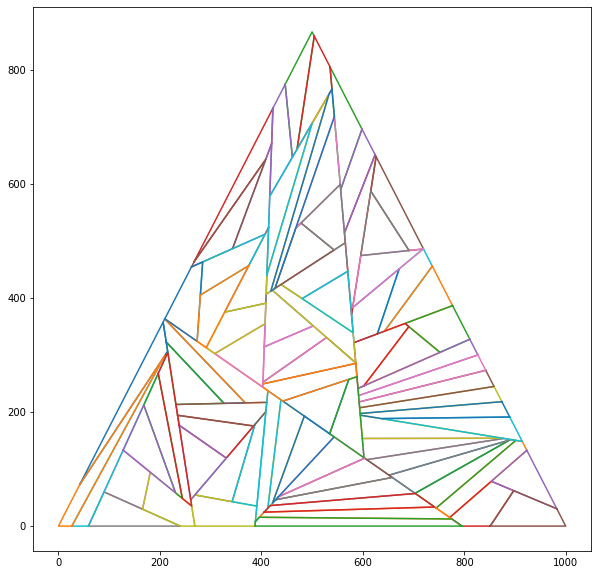

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

colors  = winners
# plot = ax.scatter(*location.T, s=0.01, c=winners, alpha=0.5, cmap='rainbow')

for district in districts:
    plt.plot(*district.exterior.xy)

# Save to dat file

In [40]:
num_voters, num_parties = 333333, 2

district_boundaries = [
    [len(district.boundary.coords)] + [p for x in district.boundary.coords for p in x] 
    for district in districts
]
num_districts = len(district_boundaries)

fmt_boundary = []
for boundary in district_boundaries:
    fmt_boundary.append(str(boundary[0]) + " " + "".join(map(lambda x:f"{x:f} ", boundary[1:])))

with open(f"tour3_81districts_party3.dat", "w") as handle:
    np.savetxt(handle, mmap, fmt="%f", delimiter=' ', header=f"{num_voters} {num_parties}", comments='')
    np.savetxt(handle, np.array(fmt_boundary), fmt="%s", header=f"{num_districts}", comments='')